## Welcome back to Python Notebooks!

Didja miss me??

### And welcome to Week 4, Day 2 - introducing LangGraph!

In [1]:
from typing import Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
import random


In [2]:
# Some useful constants

nouns = ["Cabbages", "Unicorns", "Toasters", "Penguins", "Bananas", "Zombies", "Rainbows", "Eels", "Pickles", "Muffins"]
adjectives = ["outrageous", "smelly", "pedantic", "existential", "moody", "sparkly", "untrustworthy", "sarcastic", "squishy", "haunted"]

In [3]:
# Our favorite first step! Crew was doing this for us, by the way.
load_dotenv(override=True)


True

In [11]:
def shout(text: Annotated[str, "something to be shouted"]) -> str:
    print(text.upper())
    return text.upper()

shout("hello")

HELLO


'HELLO'

### A word about "Annotated"

You probably know this; type hinting is a feature in Python that lets you specify the type of something:

`my_favorite_things: List`

But you may not know this:

You can also use something called "Annotated" to add extra information that somebody else might find useful:

`my_favorite_things: Annotated[List, "these are a few of mine"]`

LangGraph needs us to use this feature when we define our State object.

It wants us to tell it what function it should call to update the State with a new value.

This function is called a **reducer**.

LangGraph provides a default reducer called `add_messages` which takes care of the most common case.

And that hopefully explains why the State looks like this.




### Step 1: Define the State object

You can use any python object; but it's most common to use a TypedDict or a Pydantic BaseModel.

In [12]:

class State(BaseModel):
        
    messages: Annotated[list, add_messages]


### Step 2: Start the Graph Builder with this State class

In [13]:
graph_builder = StateGraph(State)

### Step 3: Create a Node

A node can be any python function.

The reducer that we set before gets automatically called to combine this response with previous responses


In [14]:
def our_first_node(old_state: State) -> State:

    reply = f"{random.choice(nouns)} are {random.choice(adjectives)}"
    messages = [{"role": "assistant", "content": reply}]

    new_state = State(messages=messages)

    return new_state

graph_builder.add_node("first_node", our_first_node)

### Step 4: Create Edges

In [15]:
graph_builder.add_edge(START, "first_node")
graph_builder.add_edge("first_node", END)

### Step 5: Compile the Graph

In [16]:
graph = graph_builder.compile()

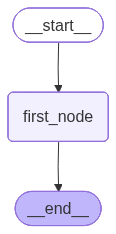

In [17]:
display(Image(graph.get_graph().draw_mermaid_png()))

### That's it! Showtime!

In [ ]:
def chat(user_input: str, history):
    message = {"role": "user", "content": user_input}
    messages = [message]
    state = State(messages=messages)
    result = graph.invoke(state)
    print(result)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

### But why did I show you that?

To make the point that LangGraph is all about python functions - it doesn't need to involve LLMs!!

Now we'll do the 5 steps again, but in 1 shot:

In [4]:
# Step 1: Define the State object
class State(BaseModel):
    messages: Annotated[list, add_messages]


In [5]:
# Step 2: Start the Graph Builder with this State class
graph_builder = StateGraph(State)


In [6]:
# Step 3: Create a Node

llm = ChatOpenAI(model="gpt-4o-mini")

def chatbot_node(old_state: State) -> State:
    response = llm.invoke(old_state.messages)
    new_state = State(messages=[response])
    return new_state

graph_builder.add_node("chatbot", chatbot_node)

In [7]:
# Step 4: Create Edges
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

In [15]:
graph = graph_builder.compile()
print(graph.get_graph().draw_mermaid())

import base64
import zlib


simple = "graph TD;\n    A --> B"

encoded = base64.urlsafe_b64encode(zlib.compress(simple.encode("utf-8"), 9)).decode("utf-8")
url = f"https://mermaid.ink/img/{encoded}?type=png"
print(url)

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	chatbot(chatbot)
	__end__([<p>__end__</p>]):::last
	__start__ --> chatbot;
	chatbot --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc

https://mermaid.ink/img/eNpLL0osyFAIcbHmUgACRwVdXTsFJwA_ngTr?type=png


In [17]:
# Step 5: Compile the Graph
graph = graph_builder.compile()
# display(Image(graph.get_graph().draw_mermaid_png()))

### That's it! And, let's do this:

In [19]:
def chat(user_input: str, history):
    messages = history + [{"role": "user", "content": user_input}]
    initial_state = State(messages=messages)
    result = graph.invoke(initial_state)
    return result['messages'][-1].content



gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.
